<a href="https://colab.research.google.com/github/Nierze/Brain-Tumor-classifier-with-pytorch/blob/main/Brain%20Tumor%20Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Computer Vision notebook  
#### By: Melchor Filippe S. Bulanon
#### Dataset downloaded from Kaggle

# Data Preparation

## Download the Data from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Ren\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1


## Check the downloaded data in your system

### Turn path into a path object

In [2]:
from pathlib import Path
path = Path(path)
path

WindowsPath('C:/Users/Ren/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1')

### Make a function to visualize the structure of the downloaded data

In [3]:
!pip install anytree

In [4]:
import os
from anytree import Node, RenderTree

def build_tree(dir_path, parent_node=None):
    # Create a node for the current directory
    dir_name = os.path.basename(dir_path)

    # Count the number of files in the directory
    file_count = sum(1 for entry in os.scandir(dir_path) if entry.is_file())

    # Append "(n files)" to the directory name if it contains files
    if file_count > 0:
        dir_name += f" ({file_count} files)"

    current_node = Node(dir_name, parent=parent_node)

    # Add subdirectories as child nodes
    with os.scandir(dir_path) as entries:
        for entry in entries:
            if entry.is_dir():
                build_tree(entry.path, current_node)  # Recursively add subdirectories

    return current_node

def inspect_data(dir_path):
    root_node = build_tree(dir_path)
    for pre, _, node in RenderTree(root_node):
        print(f"{pre}{node.name}")

In [5]:
path

WindowsPath('C:/Users/Ren/.cache/kagglehub/datasets/murtozalikhon/brain-tumor-multimodal-image-ct-and-mri/versions/1')

In [6]:
inspect_data(path)

1
└── Dataset
    ├── Brain Tumor CT scan Images (1 files)
    │   ├── Healthy (2300 files)
    │   └── Tumor (2318 files)
    ├── Brain Tumor MRI images (1 files)
    │   ├── Healthy (2000 files)
    │   └── Tumor (3000 files)
    ├── CT Split
    │   ├── Test
    │   │   ├── Healthy (572 files)
    │   │   └── Tumor (582 files)
    │   └── Train
    │       ├── Healthy (1728 files)
    │       └── Tumor (1733 files)
    └── MRI Split
        ├── Test
        │   ├── Healthy (403 files)
        │   └── Tumor (470 files)
        └── Train
            ├── Healthy (1203 files)
            └── Tumor (1415 files)


### Check datatypes in the Directories

In [7]:
file_extensions = set(p.suffix for p in (path).rglob("*") if p.is_file())
file_extensions.remove('.txt')
file_extensions

{'.jpeg', '.jpg', '.png'}

### Make function to remove duplicates from the data

In [8]:
import hashlib


def hash_file(file_path):
    """Calculate MD5 hash of file content."""
    hasher = hashlib.md5()
    with open(file_path, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def deduplicate_image_paths(image_paths):
    """Remove duplicate images based on content hash."""
    seen_hashes = set()
    deduplicated = []
    for path in image_paths:
        file_hash = hash_file(path)
        if file_hash not in seen_hashes:
            seen_hashes.add(file_hash)
            deduplicated.append(path)
    return deduplicated

### Separate the CT Scan Images from the MRI and remove duplicaates

In [9]:
image_paths_CT = [p for ext in file_extensions for p in path.glob(f"*/Brain Tumor CT scan Images/*/*{ext}")]
image_paths_CT = deduplicate_image_paths(image_paths_CT)  
image_paths_MRI = [p for ext in file_extensions for p in path.glob(f"*/Brain Tumor MRI images/*/*{ext}")]
image_paths_MRI = deduplicate_image_paths(image_paths_MRI) 

image_paths = [p for ext in file_extensions for p in path.glob(f"*/*/*/*{ext}")]


## Balance the amount of Tumor and Healthy images in MRI
Since there are 2000 Healthy images and 3000 Tumor images, we need to balance the number of both to 2000

In [10]:
import random

tumor_paths_MRI = [p for p in image_paths_MRI if "Tumor" in p.parent.stem]
images_to_remove = random.sample(tumor_paths_MRI, 1000)
image_paths_MRI_balanced = [p for p in image_paths_MRI if p not in images_to_remove]

In [11]:
len(image_paths_MRI_balanced)

3491

## Visualize random images

### Import necessary libraries

In [12]:
import matplotlib.pyplot as plt
from PIL import Image

### Make a function to visualize random images

In [13]:
def show_random_images(path, rows, cols):
    fig = plt.figure(figsize=(9,12))
    for i in range(1, rows * cols + 1):
        fig.add_subplot(rows, cols, i)
        rand_img = random.choice(path)
        with Image.open(rand_img) as show_img:
            plt.imshow(show_img)
            plt.title(str(rand_img.parent.stem) + f"\n {show_img.size}")
            plt.axis(False)


### Visualize random CT scan images

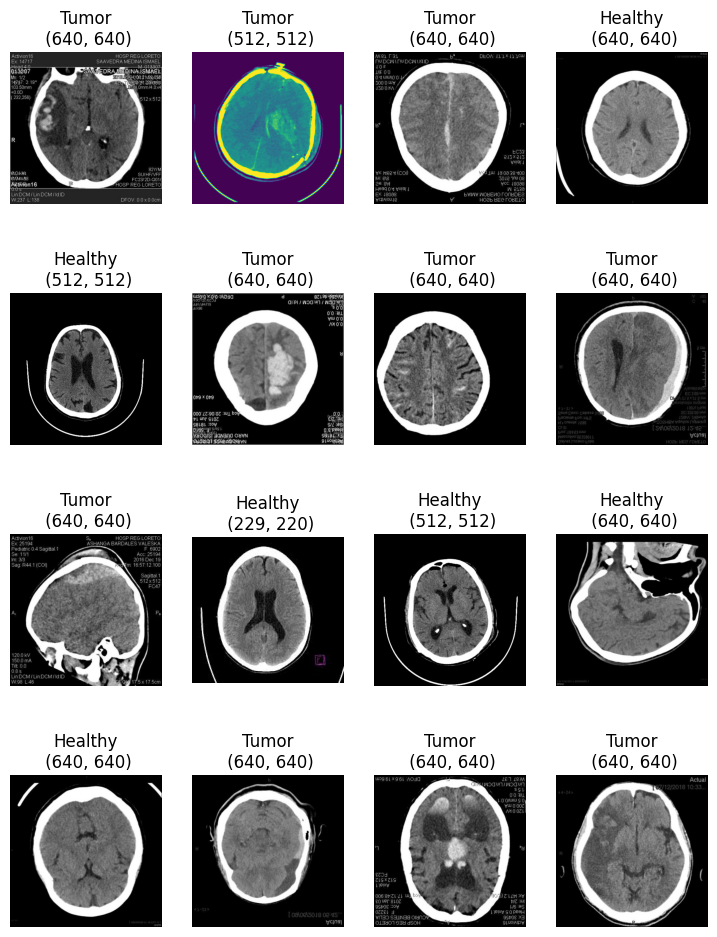

In [14]:
show_random_images(image_paths_CT, 4, 4)

### Visualize random MRI scan images

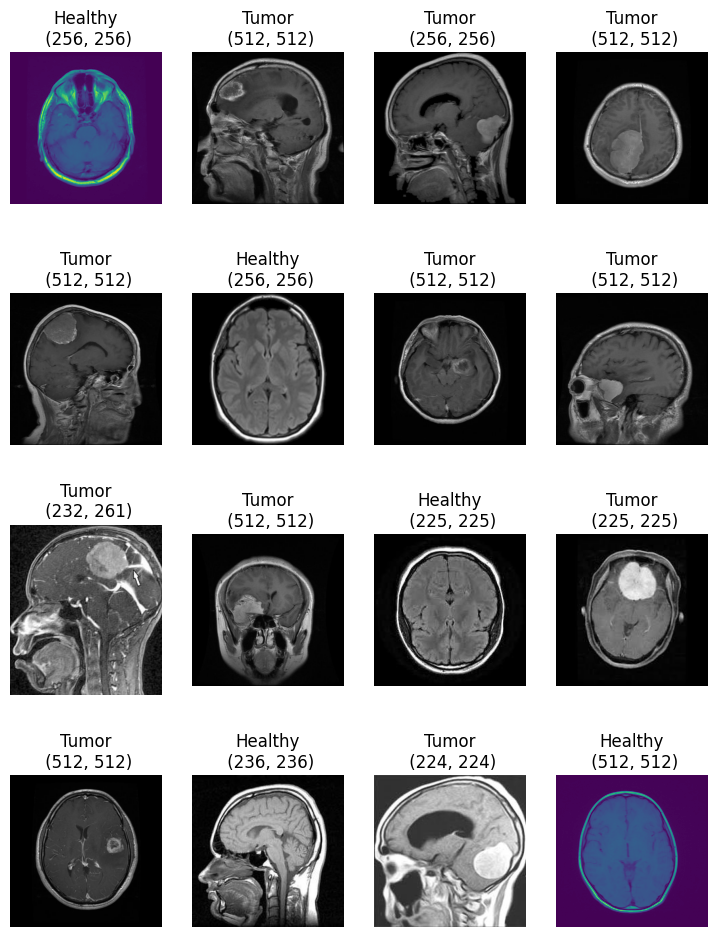

In [15]:
show_random_images(image_paths_MRI_balanced, 4, 4)

## Split CT and MRI scan images into Training and Testing sets

### Import necessary libraries

In [16]:
from sklearn.model_selection import train_test_split as tts
import shutil

### Split the CT images

In [17]:
train_CT, test_CT = tts(image_paths_CT, test_size=.25)

### Split the MRI images

In [18]:
train_MRI, test_MRI = tts(image_paths_MRI_balanced, test_size=.25)

In [19]:
len(train_MRI), len(test_MRI)

(2618, 873)

### Make a new directory containing the splitted data

In [ ]:
# Change the base path to a writable directory
# base_path = Path("/kaggle/working")  # Use Kaggle's writable directory

In [20]:
# Create train and test directorie
train_ct_path = path / "Dataset/CT Split/Train"
test_ct_path = path / "Dataset/CT Split/Test"
train_mri_path = path / "Dataset/MRI Split/Train"
test_mri_path = path / "Dataset/MRI Split/Test"

# Create directories if they don't exist
train_ct_path.mkdir(parents=True, exist_ok=True)
test_ct_path.mkdir(parents=True, exist_ok=True)
train_mri_path.mkdir(parents=True, exist_ok=True)
test_mri_path.mkdir(parents=True, exist_ok=True)

inspect_data(path)

1
└── Dataset
    ├── Brain Tumor CT scan Images (1 files)
    │   ├── Healthy (2300 files)
    │   └── Tumor (2318 files)
    ├── Brain Tumor MRI images (1 files)
    │   ├── Healthy (2000 files)
    │   └── Tumor (3000 files)
    ├── CT Split
    │   ├── Test
    │   │   ├── Healthy (572 files)
    │   │   └── Tumor (582 files)
    │   └── Train
    │       ├── Healthy (1728 files)
    │       └── Tumor (1733 files)
    └── MRI Split
        ├── Test
        │   ├── Healthy (403 files)
        │   └── Tumor (470 files)
        └── Train
            ├── Healthy (1203 files)
            └── Tumor (1415 files)


### Make a function to copy files to the new directory

In [21]:
def copy_files(files, destination, overwrite):
    if not overwrite and any(destination.iterdir()):
        print("Directory is not empty, please activate overwrite to replace current contents")
        return

    if overwrite and any(destination.iterdir()):
        shutil.rmtree(destination)
        destination.mkdir(parents=True, exist_ok=True)

    for file in files:
        dest = destination / file.parent.name / file.name
        dest.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy(str(file), str(dest))

    print("Files copied successfully.")

## Verify that there are no duplicate data

### Make a function for verification

In [22]:
def check_all_hashes(mri_split_path):
    all_hashes = set()
    duplicates = []
    for root, dirs, files in os.walk(mri_split_path):
        for file in files:
            filepath = os.path.join(root, file)
            file_hash = hash_file(filepath)
            if file_hash in all_hashes:
                duplicates.append(filepath)
            else:
                all_hashes.add(file_hash)
    print(f"Total duplicates found: {len(duplicates)}")
    return duplicates

### Copy the files

In [23]:
REPLACE_FILES = True

# Copy CT files
copy_files([], train_ct_path, REPLACE_FILES)  # Wipe directories
copy_files([], test_ct_path, REPLACE_FILES)

copy_files(train_CT, train_ct_path, REPLACE_FILES)
copy_files(test_CT, test_ct_path, REPLACE_FILES)

# Copy MRI files and clean

copy_files([], train_mri_path, REPLACE_FILES)  # Wipe directories
copy_files([], test_mri_path, REPLACE_FILES)

copy_files(train_MRI, train_mri_path, REPLACE_FILES)
copy_files(test_MRI, test_mri_path, REPLACE_FILES)

inspect_data(path)


Files copied successfully.
Files copied successfully.
Files copied successfully.
Files copied successfully.
Files copied successfully.
Files copied successfully.
Files copied successfully.
Files copied successfully.
1
└── Dataset
    ├── Brain Tumor CT scan Images (1 files)
    │   ├── Healthy (2300 files)
    │   └── Tumor (2318 files)
    ├── Brain Tumor MRI images (1 files)
    │   ├── Healthy (2000 files)
    │   └── Tumor (3000 files)
    ├── CT Split
    │   ├── Test
    │   │   ├── Healthy (584 files)
    │   │   └── Tumor (570 files)
    │   └── Train
    │       ├── Healthy (1716 files)
    │       └── Tumor (1745 files)
    └── MRI Split
        ├── Test
        │   ├── Healthy (382 files)
        │   └── Tumor (491 files)
        └── Train
            ├── Healthy (1224 files)
            └── Tumor (1394 files)


## Data Augmentation

### Import necessary libraries

In [24]:
from torchvision import transforms

### Implement a simple trivial augment

In [25]:
data_transform_trivial = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to 1-channel grayscale
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
    transforms.ToTensor(),  # Converts PIL Image to tensor (now 1 channel)
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

## Create dataset object for CT and MRI images

### Import necessary libraries

In [26]:
from torchvision import datasets

### Create the datasets

In [27]:
train_CT_dataset = datasets.ImageFolder(
    root=train_ct_path,
    transform=data_transform_trivial
)

test_CT_dataset = datasets.ImageFolder(
    root=test_ct_path,
    transform=data_transform_trivial
)

train_MRI_dataset = datasets.ImageFolder(
    root=train_mri_path,
    transform=data_transform_trivial
)

test_MRI_dataset = datasets.ImageFolder(
    root=test_mri_path,
    transform=data_transform_trivial
)

## Create dataloader object for CT and MRI images

### Import necessary libraries

In [28]:
from torch.utils.data import DataLoader

In [29]:
train_CT_dataloader = DataLoader(
    dataset=train_CT_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

test_CT_dataloader = DataLoader(
    dataset=test_CT_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False
)

train_MRI_dataloader = DataLoader(
    dataset=train_MRI_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True
)

test_MRI_dataloader = DataLoader(
    dataset=test_MRI_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=False
)

# Model Creation (MRI images)

## Import necessary libraries

In [30]:
import torch
from torch import nn
from tqdm import tqdm
from torchvision import models
from safetensors.torch import save_file, load_file


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Create a predefined ResNetmodel

### Make a function to make a modified ResNet50 model

In [32]:
def make_modified_resnet50(device, load=False, statedict=None):
    model = models.resnet50(weights=None)
    
    # Change first conv layer for grayscale
    model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
    model = model.to(device)
    
    if load and statedict:
        state_dict = load_file(statedict, device=device.type)
        model.load_state_dict(state_dict)
    
    return model
    
# tumor_classifier_resnet_0 = make_modified_resnet50(device)

## Create Training and Testing functions

In [61]:
def train_model(model, dataloader, criterion, device, num_epochs=10, lr=0.001):
    model = model.to(device) 
    model.train()
    
    # Automatically create Adam optimizer with specified learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# test_model remains unchanged
def test_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.inference_mode():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    accuracy = 100 * correct / total
    print(f"Test Loss: {round(running_loss/len(dataloader), 4)}, Accuracy: {accuracy}%")

## Model Training

### Create Loss function and Optimizer

In [57]:
loss_fn = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(tumor_classifier_resnet_0.parameters(), lr=0.001)

### Train the model

#### First Training

In [35]:
# train_model(tumor_classifier_resnet_0, train_MRI_dataloader, loss_fn, device, num_epochs=10, lr=0.001)

#### Second Training

In [36]:
# train_model(tumor_classifier_resnet_0, train_MRI_dataloader, loss_fn, device, num_epochs=10, lr=0.0001)

### Test the model

In [37]:
# test_model(tumor_classifier_resnet_0, test_MRI_dataloader, loss_fn, device)

### Save the model

In [38]:

# save_file(tumor_classifier_resnet_0.state_dict(), "tumor_classifier_resnet_0v1.safetensors")

## Model evaluation

### load the model

In [62]:
resnet50_MRI = make_modified_resnet50(device, load=True, statedict="Trained Models/tumor_classifier_resnet_0v4.safetensors")

In [63]:
test_model(resnet50_MRI, test_MRI_dataloader, loss_fn, device)

Test Loss: 0.0315, Accuracy: 98.85452462772051%


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np



def print_confusion_matrix(model, test_dataloader, train_dataloader, device):
    model.eval()  # Set model to evaluation mode
    y_true = []
    y_pred = []
    
    with torch.inference_mode():
        # Use the dataloader passed to the function (not test_CT_dataloader)
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot with correct class labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d',
        xticklabels=test_dataloader.dataset.classes,
        yticklabels=test_dataloader.dataset.classes
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Print classification report
    print(classification_report(y_true, y_pred, target_names=test_dataloader.dataset.classes))


    # Check test set class distribution
    print("Test set class counts:", np.bincount(test_dataloader.dataset.targets))

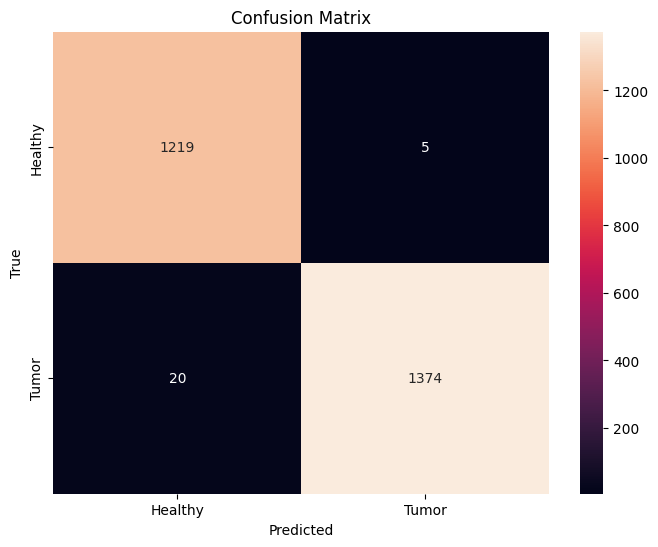

              precision    recall  f1-score   support

     Healthy       0.98      1.00      0.99      1224
       Tumor       1.00      0.99      0.99      1394

    accuracy                           0.99      2618
   macro avg       0.99      0.99      0.99      2618
weighted avg       0.99      0.99      0.99      2618

Test set class counts: [1224 1394]
Overlap between train/test: 2618


In [64]:
print_confusion_matrix(resnet50_MRI, train_MRI_dataloader, train_MRI_dataloader, device)

In [43]:
# inspect_data(path)

In [44]:

def check_mri_leakage(mri_split_path):
    train_dir = os.path.join(mri_split_path, "Train")
    test_dir = os.path.join(mri_split_path, "Test")
    
    # Get all train filenames
    train_files = []
    for root, dirs, files in os.walk(train_dir):
        for file in files:
            train_files.append(file)  # Only compare filenames, not paths
    
    # Get all test filenames
    test_files = []
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            test_files.append(file)
    
    # Find overlap
    overlap = set(train_files) & set(test_files)
    print(f"Number of overlapping files between MRI Train and Test: {len(overlap)}")
    if overlap:
        print("Example overlapping files:", list(overlap)[:5])


def hash_file(filepath):
    """Generate MD5 hash of a file's content."""
    hasher = hashlib.md5()
    with open(filepath, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def check_mri_content_leakage(mri_split_path):
    train_hashes = set()
    test_hashes = set()
    
    # Hash all train files
    for root, dirs, files in os.walk(os.path.join(mri_split_path, "Train")):
        for file in files:
            filepath = os.path.join(root, file)
            train_hashes.add(hash_file(filepath))
    
    # Hash all test files
    for root, dirs, files in os.walk(os.path.join(mri_split_path, "Test")):
        for file in files:
            filepath = os.path.join(root, file)
            test_hashes.add(hash_file(filepath))
    
    # Find overlap
    overlap = train_hashes & test_hashes
    print(f"Number of identical files in both sets: {len(overlap)}")



# MRI_split_path = path / 'Dataset' / 'MRI Split'
# inspect_data(MRI_split_path)

In [45]:
# check_mri_leakage(MRI_split_path)
# check_mri_content_leakage(MRI_split_path)

In [46]:
from collections import defaultdict

def count_classes(dataloader):
    counts = defaultdict(int)
    for batch in dataloader:
        # Extract labels from the batch (adjust based on your dataset structure)
        inputs, labels = batch  # Assumes batch is (inputs, labels)
        
        # Move labels to CPU if they're on GPU
        labels = labels.cpu()
        
        # Get unique classes and their counts in the current batch
        unique_labels, counts_per_label = torch.unique(labels, return_counts=True)
        
        # Update the total counts
        for label, count in zip(unique_labels, counts_per_label):
            counts[int(label)] += int(count)
    
    return counts



In [54]:
count_classes(dataloader=train_MRI_dataloader)

defaultdict(int, {0: 1224, 1: 1394})

In [53]:
from collections import Counter


Counter(test_MRI_dataset.targets)

Counter({1: 491, 0: 382})